# Oakland Crime频繁模式与关联规则挖掘

## 目录
- 1. 数据集简介
- 2. 数据集处理与数据项选择
- 3. 数据集频繁模式抽取
- 4. 关联规则计算及评价
- 5. 挖掘结果分析与可视化
    - 5.2 挖掘结果分析
    - 5.1 结果可视化

## 1. 数据集简介
数据集中包含了2011到2026年奥克兰地区的犯罪记录，每条记录中有11个属性，分别为：
- `Agency` 机构名称，只有缺失或者“OP”
- `Create Time` 案件创建时间
- `Location` 案件发生地点
- `Area ID` 案件发生区域ID
- `Beat` 案件发生的巡逻区
- `Priority` 案件优先级，分别为0，1，2
- `Incident Type ID` 案件类型ID
- `Incident Type Description` 案件类型
- `Event Number` 案件标号，唯一值
- `Closed Time` 案件结束时间
- `Zip Codes` 案件地区邮政编码

## 2. 数据集处理与数据项选择
为了挖掘有意义的信息，对此需要对进行挖掘的项(也就是列)进行选择，并将原数据形式转化成利于挖掘的数据格式。鉴于项之间的包含、重叠关系以及项值内容，对项进行如下处理：
为了提取有价值的关联规则，本次实验剔除了无意义的项与唯一项，最终选取的数据属性为：
- `Incident Type ID`与`Incident Type Descreiption`二者互相对应，选其一`Incident Type Descreiption`进行实验；
- `Area`,`Beat`,`Location`均表示案件发生地点，由于`Location`和`Area`属性粒度过细或过粗，这里选取`Beat`属性进行实验；
- `Start Time`和`Closed Time`属性范围过小，故二者皆取月份作为其特征表示，并根据二者差值新增`Spent Time`项，并根据差值时间不同分为多个类别。

筛除的属性有：
- `Agency` 机构名称，由于只有缺失值或者OP，剔除
- `Event Number`案件标号为一，且不具有规律性，剔除

最终处理后的数据由6项组成，分别为`Incident Type Descreiption`、`Beat`、`Start Time`、`Closed Time`和`Spent time`,处理过程如下。

In [3]:
# 读取数据集
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
%matplotlib inline

path = "./dataset/oakland_crime_statistics/records-for-{}.csv"
data = pd.concat([pd.read_csv(path.format(year)) for year in [2011,2013,2015,2016]])
data2 = pd.concat([pd.read_csv(path.format(year)) for year in [2012,2014]])
data = pd.concat([data,data2],ignore_index=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1046388 entries, 0 to 1046387
Data columns (total 12 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Agency                     1046384 non-null  object 
 1   Create Time                1046384 non-null  object 
 2   Location                   671477 non-null   object 
 3   Area Id                    864023 non-null   object 
 4   Beat                       1040583 non-null  object 
 5   Priority                   1046384 non-null  float64
 6   Incident Type Id           1046384 non-null  object 
 7   Incident Type Description  1045996 non-null  object 
 8   Event Number               1046384 non-null  object 
 9   Closed Time                1046359 non-null  object 
 10  Location 1                 374799 non-null   object 
 11  Zip Codes                  352 non-null      float64
dtypes: float64(2), object(10)
memory usage: 95.8+ MB


In [4]:

def str_to_datetime(s):
    result = s.split('T')
    date,time = s.split('T')
    date = date.split('-')
    time = time[:-4].split(':')
    date = [int(x) for x in date]
    time = [int(x) for x in time]
    return datetime.datetime(date[0],date[1],date[2],time[0],time[1],time[2])

def hierarchy(time):
    conditions = lambda x: {
        x < 10: 1, 
        10 <= x < 30: 2,
        30 <= x < 60: 3,
        60 <= x < 3*60: 4,
        3*60 <= x < 6*60: 5,
        6*60 <= x < 12*60: 6,
        12*60 <= x < 24*60: 7,
        x >= 24*60: 8,
    }
    return conditions(time)[True]

    
def time_minus(col1,col2):
    start = col1.values;
    end = col2.values;
    
    ans = []
    for s,e in zip(start,end):
        if s=='nan' : e = s 
        elif e =='nan' : s = e
        time = (str_to_datetime(e)-str_to_datetime(s)).seconds//60
        ans.append(hierarchy(time))
    return ans

def get_month(col):
    ans = []
    for i in col.values:
        date = str_to_datetime(i)
        ans.append(date.month)
    return ans

def preprocess_data(data):
    data = data.drop(['Agency','Incident Type Id','Location','Event Number','Area Id','Location 1','Zip Codes'],axis = 1)
    data['Spent Time'] = time_minus(data['Create Time'],data['Closed Time'])
    data['Create Time'] = get_month(data['Create Time'])
    data['Closed Time'] = get_month(data['Closed Time'])
    return data 

data['Create Time'] = data['Create Time'].astype(str)
data['Closed Time'] = data['Closed Time'].astype(str)
data = data.dropna(subset=['Closed Time'])
data = data.dropna(subset=['Create Time'])
data = data[(data['Create Time']!='nan')&(data['Closed Time']!='nan')]

data = preprocess_data(data)
data.head(5)

,Create Time,Beat,Priority,Incident Type Description,Closed Time,Spent Time
0,1,06X,1.0,POSSIBLE DEAD PERSON,1,2
1,1,07X,1.0,415 GUNSHOTS,1,4
2,1,10Y,2.0,415 GUNSHOTS,1,1
3,1,21Y,2.0,415 GUNSHOTS,1,1
4,1,20X,1.0,415 GUNSHOTS,1,3


使用mlxtend库进行数据挖掘，需要将数据进一步处理成其对应格式。

In [5]:
from mlxtend.frequent_patterns import apriori
from mlxtend.preprocessing import TransactionEncoder

def deal(data):
    return data.to_list()

# 增加属性前缀以增加区分度
def add_prefix(data):
    data['Create Time'] = ['s_t' + str(x) for x in data['Create Time'].values]
    data['Closed Time'] = ['e_t' + str(x) for x in data['Closed Time'].values]
    data['Spent Time'] = ['l_t' + str(x) for x in data['Spent Time'].values]
    data['Priority'] = ['p' + str(x) for x in data['Priority'].values] 
    return data

data = add_prefix(data)

data['Create Time'] = data['Create Time'].astype(str)
data['Closed Time'] = data['Closed Time'].astype(str)
data['Spent Time'] = data['Spent Time'].astype(str)
data['Priority'] = data['Priority'].astype(str)
data['Beat'] = data['Beat'].astype(str)
data['Incident Type Description'] = data['Incident Type Description'].astype(str)
# 将数据转换为列表，并用TransactionEncoder编码
data_list = data.apply(deal,axis=1).tolist()
te = TransactionEncoder()
data_list_tf = te.fit_transform(data_list)
data = pd.DataFrame(data_list_tf,columns=te.columns_)

data.head(5)

,01X,02X,02Y,03X,03Y,04X,05X,05Y,06X,07X,...,s_t11,s_t12,s_t2,s_t3,s_t4,s_t5,s_t6,s_t7,s_t8,s_t9
0,False,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


## 3. 数据集频繁模式抽取
使用Apriori算法计算频繁模式，最小支持度阈值取0.05

In [6]:
min_support = 0.05
frequent_items = apriori(data, min_support=min_support, use_colnames=True, max_len=4).sort_values(by='support', ascending=False)	
frequent_items.head(100)

,support,itemsets
22,0.778700,(p2.0)
18,0.312342,(l_t4)
66,0.234494,"(l_t4, p2.0)"
21,0.221277,(p1.0)
17,0.172000,(l_t3)
...,...,...
42,0.054734,"(p2.0, e_t11)"
83,0.054459,"(p2.0, s_t11, e_t11)"
68,0.053733,"(p2.0, l_t6)"
0,0.052501,(911 HANG-UP)


## 4. 关联规则导出与评价

这里使用的评价方法有教材中的`Lift`,`Allconf`,`cosine`,`Jaccard`,`Maxconf`以及`Kulczynski`,导出规则表按`Lift`进行降序排序。

In [7]:
# 使用不同的评价指标进行计算
import math
from mlxtend.frequent_patterns import association_rules
	
def allconf(item):
    return item.support/max(item['antecedent support'],item['consequent support'])
def cosine(item):
    return item.support/math.sqrt(item['antecedent support']*item['consequent support'])
def Jaccard(item):
    return item.support/(item['antecedent support']+item['consequent support']-item.support)
def maxconf(item):
    return max(item.support/item['antecedent support'],item.support/item['consequent support'])
def Kulczynski(item):
    return 0.5*(item.support/item['antecedent support']+item.support/item['consequent support'])

def metrics(r,f):
    ans = []
    for i in range(r.shape[0]):
        item = r.iloc[i]
        ans.append(f(item))
    return ans
rules =  association_rules(frequent_items, metric='lift')
rules = rules.sort_values(by=['lift'], ascending=False).reset_index(drop=True)
rules = rules.drop(['leverage','conviction'],axis = 1)
rules['cosine'] = metrics(rules,cosine)
rules['Jaccard'] = metrics(rules,Jaccard)
rules['Allconf'] = metrics(rules,allconf)
rules['Maxconf'] = metrics(rules,maxconf)
rules['Kulczynski'] = metrics(rules,Kulczynski)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,cosine,Jaccard,Allconf,Maxconf,Kulczynski
0,(s_t11),"(p2.0, e_t11)",0.070393,0.054734,0.054459,0.773650,14.134835,0.877367,0.770648,0.773650,0.994989,0.884320
1,"(p2.0, e_t11)",(s_t11),0.054734,0.070393,0.054459,0.994989,14.134835,0.877367,0.770648,0.773650,0.994989,0.884320
2,(e_t11),"(p2.0, s_t11)",0.070409,0.054744,0.054459,0.773472,14.128860,0.877182,0.770356,0.773472,0.994798,0.884135
3,"(p2.0, s_t11)",(e_t11),0.054744,0.070409,0.054459,0.994798,14.128860,0.877182,0.770356,0.773472,0.994798,0.884135
4,(e_t11),(s_t11),0.070409,0.070393,0.070020,0.994476,14.127545,0.994590,0.989239,0.994476,0.994705,0.994590
...,...,...,...,...,...,...,...,...,...,...,...,...
159,(p2.0),(l_t4),0.778700,0.312342,0.234494,0.301135,0.964120,0.475479,0.273766,0.301135,0.750760,0.525948
160,(p2.0),(l_t3),0.778700,0.172000,0.128378,0.164861,0.958495,0.350784,0.156116,0.164861,0.746380,0.455621
161,(l_t3),(p2.0),0.172000,0.778700,0.128378,0.746380,0.958495,0.350784,0.156116,0.164861,0.746380,0.455621
162,(l_t2),(p2.0),0.141419,0.778700,0.104859,0.741477,0.952198,0.315985,0.128620,0.134659,0.741477,0.438068


## 5. 挖掘结果分析与可视化
对按`Lift`评分前10条规则进行分析：

In [8]:
rules = rules.sort_values(by=['lift'], ascending=False).reset_index(drop=True)
rules.head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,cosine,Jaccard,Allconf,Maxconf,Kulczynski
0,(s_t11),"(p2.0, e_t11)",0.070393,0.054734,0.054459,0.773650,14.134835,0.877367,0.770648,0.773650,0.994989,0.884320
1,"(p2.0, e_t11)",(s_t11),0.054734,0.070393,0.054459,0.994989,14.134835,0.877367,0.770648,0.773650,0.994989,0.884320
2,(e_t11),"(p2.0, s_t11)",0.070409,0.054744,0.054459,0.773472,14.128860,0.877182,0.770356,0.773472,0.994798,0.884135
3,"(p2.0, s_t11)",(e_t11),0.054744,0.070409,0.054459,0.994798,14.128860,0.877182,0.770356,0.773472,0.994798,0.884135
4,(e_t11),(s_t11),0.070409,0.070393,0.070020,0.994476,14.127545,0.994590,0.989239,0.994476,0.994705,0.994590
5,(s_t11),(e_t11),0.070393,0.070409,0.070020,0.994705,14.127545,0.994590,0.989239,0.994476,0.994705,0.994590
6,(s_t12),"(p2.0, e_t12)",0.073343,0.057119,0.056836,0.774937,13.567059,0.878123,0.771960,0.774937,0.995047,0.884992
7,"(p2.0, e_t12)",(s_t12),0.057119,0.073343,0.056836,0.995047,13.567059,0.878123,0.771960,0.774937,0.995047,0.884992
8,"(p2.0, s_t12)",(e_t12),0.057163,0.073297,0.056836,0.994282,13.565110,0.878059,0.771980,0.775422,0.994282,0.884852
9,(e_t12),"(p2.0, s_t12)",0.073297,0.057163,0.056836,0.775422,13.565110,0.878059,0.771980,0.775422,0.994282,0.884852


- 所给规则的lift都是远大于1的，说明关联项之间是正相关的
- 0-3项关联规则 表明了优先级为2的案件通常在一个月内(11月)就会解决，优先级为2的案子大多都是小案件，解决速度较快。
- 规则4，5说明在11月发生的案件可以得到很快的解决。
- 规则6，9说明在12月优先级为2的案子也会得到很好的解决

### 5.2 关联规则可视化
  
x轴和y轴分别代表了关联规则的支持度和置信度，其颜色的深浅则反应了`Lift`评分的大小

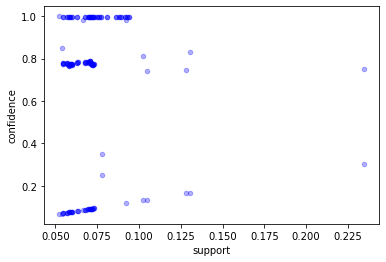

In [9]:
import  matplotlib.pyplot as plt
plt.xlabel('support')
plt.ylabel('confidence')
for i in range(rules.shape[0]):
    plt.scatter(rules.support[i],rules.confidence[i],s=20,c='b',alpha=(rules.lift.iloc[i])/(rules.lift.iloc[0])*0.8/(rules.lift.iloc[0]-rules.lift.iloc[-1])+0.3)